In [163]:
# Install required packages
%pip install pandas numpy scikit-learn xgboost matplotlib seaborn kaggle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBRegressor
import json
from ast import literal_eval
import warnings
warnings.filterwarnings('ignore')

# Load the data (assuming you've downloaded from Kaggle)
movies_df = pd.read_csv('movies_metadata.csv', low_memory=False)

Note: you may need to restart the kernel to use updated packages.


Data Preprocessing

In [164]:
def preprocess_data(df):
    ## Convert revenue to number vars and get rid of null/0 revenues
    df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')
    df = df[df['revenue'] > 0]
    
    ## Convert budget to number var
    df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
    
    ## Convert vote stuff to number vars
    df['vote_count'] = pd.to_numeric(df['vote_count'], errors='coerce')
    df['vote_average'] = pd.to_numeric(df['vote_average'], errors='coerce')
    
    ## Get year
    df['release_year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year

    df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce')
    
    ## Parse csvs
    for col in ['genres', 'production_companies', 'production_countries']:
        df[col] = df[col].apply(lambda x: literal_eval(x) if isinstance(x, str) else [])
        df[f'{col}_names'] = df[col].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
    
    ## Create binary features for popular genres
    top_genres = ['Action', 'Comedy', 'Drama', 'Adventure', 'Thriller']
    for genre in top_genres:
        df[f'genre_{genre.lower()}'] = df['genres_names'].apply(lambda x: 1 if genre in x else 0)
    
    ## Drop unneeded columns
    df = df.drop(columns=['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 
                         'overview', 'tagline', 'title', 'original_title', 'status', 
                         'video', 'original_language', 'spoken_languages', 'genres', 
                         'production_companies', 'production_countries', 'genres_names',
                         'production_companies_names', 'production_countries_names'])
    
    return df

movies_clean = preprocess_data(movies_df)

Feature Engineering / Target Selection

In [165]:
## Select features / target
features = ['budget', 'popularity', 'runtime', 'vote_count', 'vote_average', 
            'release_year', 'genre_action', 'genre_comedy', 'genre_drama', 
            'genre_adventure', 'genre_thriller']
target = 'revenue'

## Remove missing values
movies_clean = movies_clean.dropna(subset=features + [target])

## Log-transform revenue, popularity and budget
movies_clean['log_revenue'] = np.log1p(movies_clean['revenue'])
movies_clean['log_budget'] = np.log1p(movies_clean['budget'])
movies_clean['log_popularity'] = np.log1p(np.clip(movies_clean['popularity'], a_min=1, a_max=5000))

## Update feats to use log_budget and log_popularity
features = ['log_budget', 'log_popularity', 'runtime', 'vote_count', 'vote_average', 
            'release_year', 'genre_action', 'genre_comedy', 'genre_drama', 
            'genre_adventure', 'genre_thriller']

target = 'log_revenue'

Feature Scaling / Train-Test Split

In [166]:
## Split data
X = movies_clean[features]
y = movies_clean[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Numeric / categorical features
numeric_features = ['log_budget', 'log_popularity', 'runtime', 'vote_count', 'vote_average', 'release_year']
categorical_features = ['genre_action', 'genre_comedy', 'genre_drama', 'genre_adventure', 'genre_thriller']

## Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', 'passthrough', categorical_features)
    ])

## Add to modeling pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42))
])

Model Training / Evaluation

In [ ]:
## Train
pipeline.fit(X_train, y_train)

## Calculate feat importance
xgb_model = pipeline.named_steps['regressor']
importances = xgb_model.feature_importances_
feature_names = ['log_budget', 'log_popularity', 'runtime', 'vote_count', 
                'vote_average', 'release_year'] + categorical_features

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(importance_df.sort_values('Importance', ascending=False))

## Calculate prediction
y_pred = pipeline.predict(X_test)

## Convert back from log scale
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)

## Eval metrics
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt((1 / len(y_pred)) * np.sum((y_true - y_pred)**2))
    r2 = r2_score(y_true, y_pred)
    
    ## for print, comment out if needed
    print("\nModel Evaluation:\n")
    print(f"Mean Squared Error: {mse:,.2f}")
    print(f"Mean Absolute Error: {mae:,.2f}")
    print(f"R-squared: {r2:.4f}")
    print(f"RSME: {rmse:,.4f}")
    
    return mse, mae, r2, rmse

eval = evaluate_model(y_test_exp, y_pred_exp)

            Feature  Importance
0        log_budget    0.301888
3        vote_count    0.137773
9   genre_adventure    0.097842
5      release_year    0.086509
1    log_popularity    0.081063
7      genre_comedy    0.055813
8       genre_drama    0.054490
2           runtime    0.052191
4      vote_average    0.051717
6      genre_action    0.043842
10   genre_thriller    0.036872

Model Evaluation:

Mean Squared Error: 5,067,472,930,716,630.00
Mean Absolute Error: 31,917,559.57
R-squared: 0.7741
RSME: 71,186,184.9709


Feature Importance Analysis

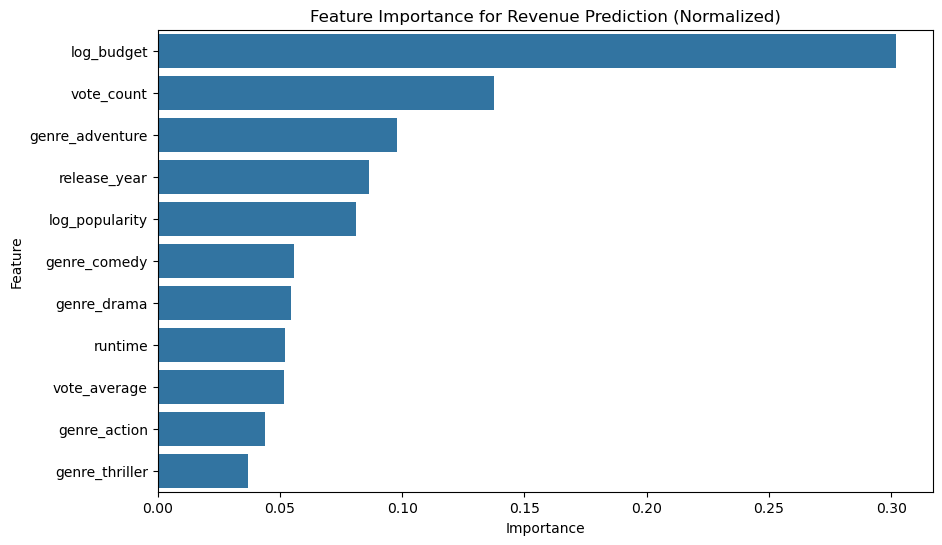

In [168]:
xgb_model = pipeline.named_steps['regressor']
importances = xgb_model.feature_importances_

feature_names = numeric_features + categorical_features

## Importance df
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

## Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y='Feature', data=importance_df)
plt.title('Feature Importance for Revenue Prediction (Normalized)')
plt.show()

Prediction Function

In [169]:
"""
Predicts movie revenue based on input features.
All parameters should be numeric values.
Genre flags should be 0 (no) or 1 (yes).
"""
def predict_movie_revenue(budget, popularity, runtime, vote_count, vote_average, 
                         release_year, is_action, is_comedy, is_drama, 
                         is_adventure, is_thriller):
    """
    Parameter constraints:
    Predict movie revenue based on input features.
    All parameters should be numeric values.
    Genre flags should be 0 (no) or 1 (yes).
    """
    ## input df
    input_data = pd.DataFrame({
        'log_budget': [np.log1p(budget)],
        'log_popularity': [popularity],
        'runtime': [runtime],
        'vote_count': [vote_count],
        'vote_average': [vote_average],
        'release_year': [release_year],
        'genre_action': [is_action],
        'genre_comedy': [is_comedy],
        'genre_drama': [is_drama],
        'genre_adventure': [is_adventure],
        'genre_thriller': [is_thriller]
    })
    
    # Make prediction
    log_pred = pipeline.predict(input_data)
    pred_revenue = np.expm1(log_pred)[0]
    
    return pred_revenue

## Test:
def make_prediction_to_string(budget, popularity, runtime, vote_count, vote_average,
    release_year, is_action, is_comedy, is_drama, is_adventure, is_thriller):

    predicted_revenue = predict_movie_revenue ( budget, popularity, runtime, vote_count, vote_average,
    release_year, is_action, is_comedy, is_drama, is_adventure, is_thriller)
    
    print(f"Predicted Revenue: ${predicted_revenue:,.2f}")

## Test here:
make_prediction_to_string(
    budget=100000000,  # $100 mill
    popularity=100,
    runtime=120,
    vote_count=100,
    vote_average=7.5,
    release_year=2023,
    is_action=1,
    is_comedy=0,
    is_drama=0,
    is_adventure=1,
    is_thriller=0
)


Predicted Revenue: $106,449,472.00


Visualizations for Debugging

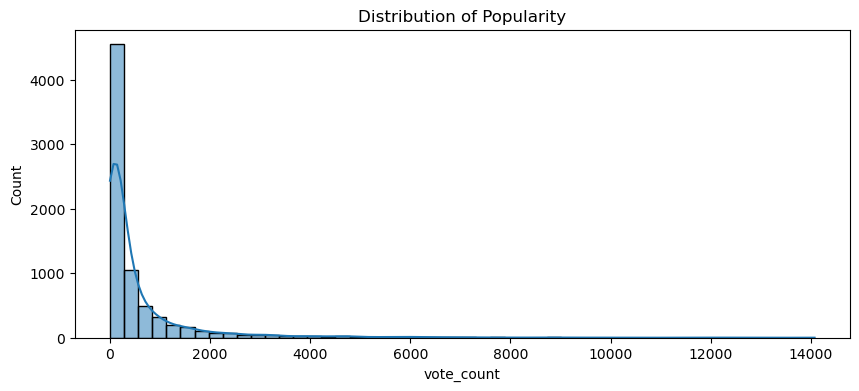

In [170]:
plt.figure(figsize=(10, 4))
sns.histplot(movies_clean['vote_count'], bins=50, kde=True)
plt.title("Distribution of Popularity")
plt.show()

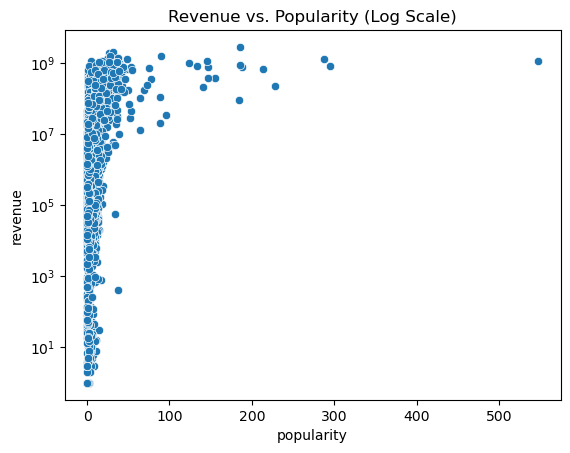

In [171]:
# Plot revenue vs. popularity
sns.scatterplot(x='popularity', y='revenue', data=movies_clean)
plt.yscale('log')
plt.title("Revenue vs. Popularity (Log Scale)")
plt.show()